Hacemos una EDA para ver el comportamiento de las variables y sus relaciones para ver como afectan a otras y tambien como afectan la variable target que es aqui si un cliente ha suscrito a un deposito a plazo.

# LIBRAIRIES

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import zscore, f_oneway
from scipy.stats import ttest_ind
from sklearn.feature_selection import mutual_info_classif
import missingno as msno
from sklearn.preprocessing import TargetEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
ruta=r"..\data\fin_mark_full_mod.csv"
df_raw=pd.read_csv(ruta,sep=";")
df_raw.shape

(41188, 21)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41093 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Vamos a cambiar el tipo de algunas de variables porque no estan bien hechas (ej: is_suscribed in object, nr.employed in object)

In [5]:
df_raw['is_suscribed'] = df_raw['is_suscribed'].astype('object')
df_raw['nr.employed'] = df_raw['nr.employed'].astype('object')

In [6]:
df_raw.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,is_suscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [7]:
df_raw.isnull().sum()[df_raw.isnull().sum()>0].sort_values(ascending=False)

housing         990
loan            990
emp.var.rate     95
euribor3m        60
dtype: int64

Tenemos nulos que tratar y tambien tendremos que aprofundizar la variable marital porque parece que tenemos nulos pero no sabemos como estan registrados.

In [69]:
df_raw.duplicated().sum()

np.int64(12)

Tenemos duplicados que vamos a eliminar

In [70]:
df_raw.drop_duplicates(inplace=True)
df_raw.shape

(41176, 21)

In [8]:
numeric_cols = [col for col in df_raw.columns if df_raw[col].dtype in ['int64', 'float64']]
str_cols = [col for col in df_raw.columns if df_raw[col].dtype == 'object']
print(f"Numeric columns: {numeric_cols}")
print(f"String columns: {str_cols}")

Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
String columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'nr.employed', 'is_suscribed']


# ANALISIS UNIVARIANTE

In [9]:
for col in df_raw.columns:
    value_counts = df_raw[col].value_counts().head(10)
    percentage = round(value_counts/df_raw.shape[0] * 100,2)
    print("\033[1m\033[4m" + col + "\033[0m")
    print(pd.DataFrame({'Valeur': value_counts.index, 'Nombre': value_counts.values, 'Pourcentage': percentage.values}))
    print(f"Type {df_raw[col].dtype}")
    print("-----------------------------")

age
   Valeur  Nombre  Pourcentage
0      31    1947         4.73
1      32    1846         4.48
2      33    1833         4.45
3      36    1780         4.32
4      35    1759         4.27
5      34    1745         4.24
6      30    1714         4.16
7      37    1475         3.58
8      29    1453         3.53
9      39    1432         3.48
Type int64
-----------------------------
job
          Valeur  Nombre  Pourcentage
0         admin.   10422        25.30
1    blue-collar    9254        22.47
2     technician    6743        16.37
3       services    3969         9.64
4     management    2924         7.10
5        retired    1720         4.18
6   entrepreneur    1456         3.54
7  self-employed    1421         3.45
8      housemaid    1060         2.57
9     unemployed    1014         2.46
Type object
-----------------------------
marital
     Valeur  Nombre  Pourcentage
0   married   24928        60.52
1    single   11568        28.09
2  divorced    4612        11.20
3   unknow

Sobre la variable marital tenemos 80 'unknown' que podemos afectar como NaN o simplemente cambiar por la moda. Tenemos el mismo problema sobre la education y tambien default pero no bamos a imputar default porque los unknowns representant 20%\
Por la variable target, vemos que tenemos una menor populacion de personas que han suscrito a un deposito a plazo (11%). se puede afectar el modelo mas tarde (pensar en un undersampling y bien hacer la estratificacion).

## QUANTITATIVE

In [10]:
df_raw[numeric_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T.style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
age,41188.000000,40.024060,10.421250,17.000000,32.000000,38.000000,47.000000,55.000000,58.000000,71.000000,98.000000
duration,41188.000000,258.285010,259.279249,0.000000,102.000000,180.000000,319.000000,551.000000,752.650000,1271.130000,4918.000000
campaign,41188.000000,2.567593,2.770014,1.000000,1.000000,2.000000,3.000000,5.000000,7.000000,14.000000,56.000000
pdays,41188.000000,-0.741988,1.510327,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6.000000,27.000000
previous,41188.000000,0.172963,0.494901,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,7.000000
emp.var.rate,41093.000000,0.081194,1.571155,-3.400000,-1.800000,1.100000,1.400000,1.400000,1.400000,1.400000,1.400000
cons.price.idx,41188.000000,93.575664,0.578840,92.201000,93.075000,93.749000,93.994000,94.465000,94.465000,94.465000,94.767000
cons.conf.idx,41188.000000,-40.502600,4.628198,-50.800000,-42.700000,-41.800000,-36.400000,-36.100000,-33.600000,-26.900000,-26.900000
euribor3m,41128.000000,3.620922,1.734545,0.634000,1.344000,4.857000,4.961000,4.964000,4.966000,4.968000,5.045000


Parece con este visual que tenemos outliers porque tenemos valores atypicas en duration, campain, pdays, previous porque hay una gran diferencia entre el percentil 95% y 99% y el maximo. Tenemos que hacer una visualizacion para ver esto mas en detalle.

In [11]:
df_raw[numeric_cols].skew().sort_values(ascending=False)

pdays             7.322378
campaign          4.762507
previous          3.832042
duration          3.263141
age               0.784697
cons.conf.idx     0.303180
cons.price.idx   -0.230888
euribor3m        -0.708746
emp.var.rate     -0.723369
dtype: float64

In [12]:
df_raw[numeric_cols].kurt().sort_values(ascending=False)

pdays             64.002998
campaign          36.979795
duration          20.247938
previous          20.108816
age                0.791312
cons.conf.idx     -0.358558
cons.price.idx    -0.829809
emp.var.rate      -1.063573
euribor3m         -1.407425
dtype: float64

Parece que tenemos variables con distribucion con no tan asymetria (exepto pdays que tiene una gran cola a la derecha) y tenemos algunas con un gran curtosis como pdays y campain asi parece que hay picos. Con esta analysis, confirmamos que tenemos grand colas a la derecha con pdays, duration, campain y previous.

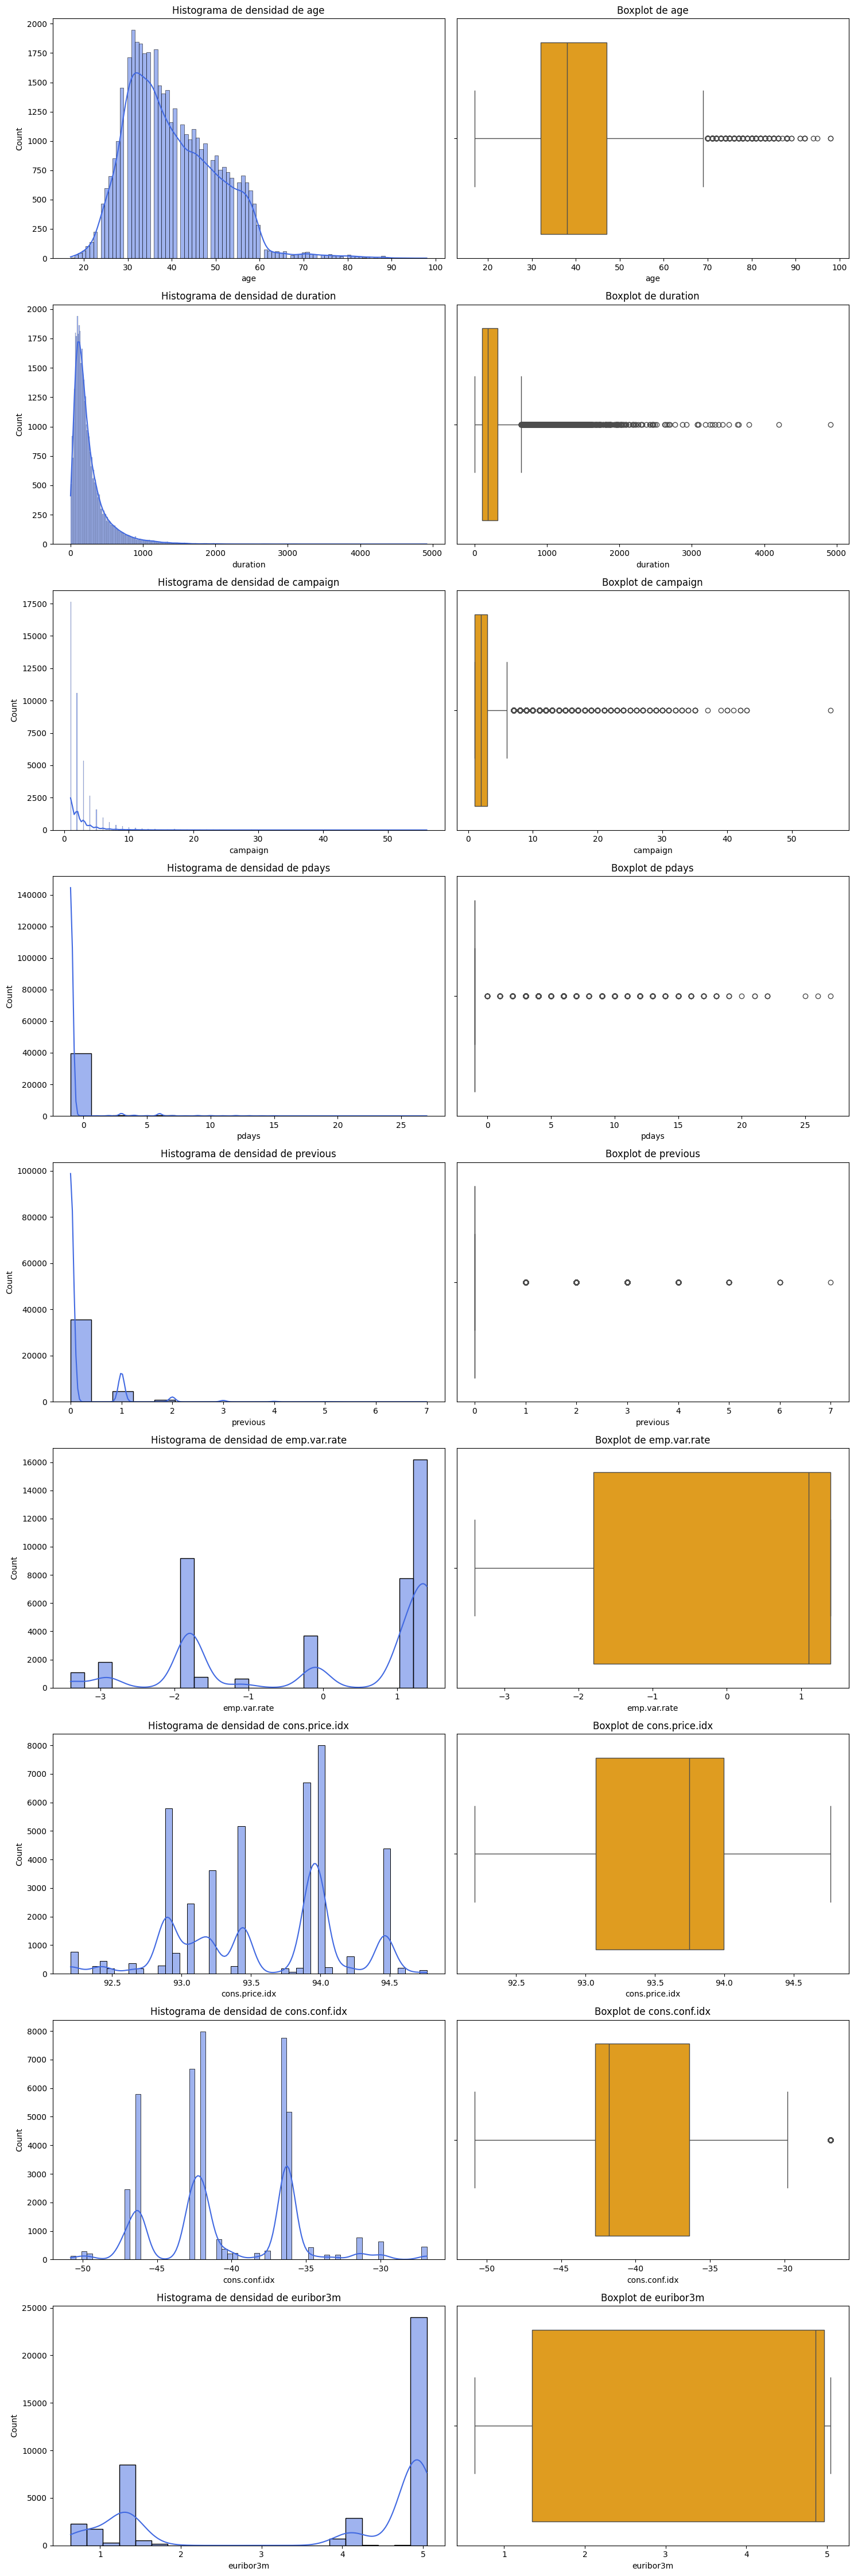

In [13]:
fig, axes = plt.subplots(nrows=len(df_raw[numeric_cols].columns), ncols=2, figsize=(15, 5 * len(df_raw[numeric_cols].columns)))

for i, column in enumerate(df_raw[numeric_cols]):
    # Histograma de densidad
    sns.histplot(df_raw[column], kde=True, ax=axes[i, 0], color='royalblue')
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
    # Boxplot
    sns.boxplot(x=df_raw[column], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Boxplot de {column}')



plt.tight_layout()
plt.show()

Podemos aplicar una transformacion sobre la duration porque tenemos una grand cola.

<Axes: xlabel='duration', ylabel='Count'>

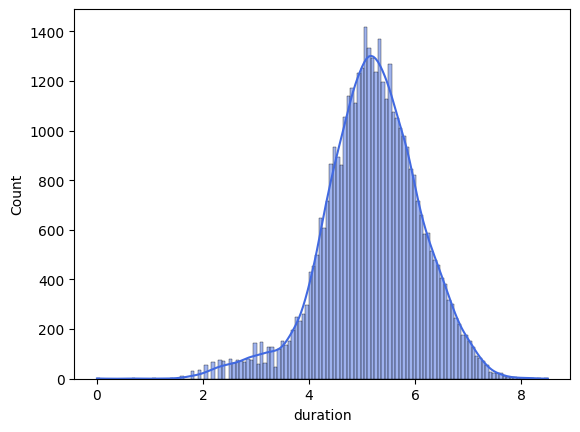

In [14]:
Duration_log = np.log(df_raw["duration"]+1)
sns.histplot(Duration_log, kde=True, color='royalblue')

Con la aplicacion del logaritmo parece que tenemos una mejor distribucion (normal) de la variable duration. Es que tenemos una gran concentracion a la media. 

In [15]:
def outlier_metrics(df, quant_vars):
    results = {}
    total = df.shape[0]
    for col in quant_vars:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_threshold = Q3 + 1.5 * IQR
        percentile_95 = df[col].quantile(0.95)
        percentile_90 = df[col].quantile(0.90)

        pct_above_IQR = (df[col] > upper_threshold).mean() * 100
        pct_above_95 = (df[col] > percentile_95).mean() * 100
        pct_above_90 = (df[col] > percentile_90).mean() * 100

        results[col] = {
            "Q3 + 1.5IQR": upper_threshold,
            "% > Q3 + 1.5IQR": round(pct_above_IQR, 2),
            "P95": percentile_95,
            "% > P95": round(pct_above_95, 2),
            "P90": percentile_90,
            "% > P90": round(pct_above_90, 2)
        }
    
    return pd.DataFrame.from_dict(results, orient='index')

metrics_df = outlier_metrics(df_raw, numeric_cols)
print(metrics_df)


                Q3 + 1.5IQR  % > Q3 + 1.5IQR      P95  % > P95      P90  \
age                 69.5000             1.14   58.000     4.02   55.000   
duration           644.5000             7.19  752.650     5.00  551.000   
campaign             6.0000             5.84    7.000     4.31    5.000   
pdays               -1.0000             3.68   -1.000     3.68   -1.000   
previous             0.0000            13.66    1.000     2.58    1.000   
emp.var.rate         6.2000             0.00    1.400     0.00    1.400   
cons.price.idx      95.3725             0.00   94.465     0.81   94.465   
cons.conf.idx      -26.9500             1.09  -33.600     4.89  -36.100   
euribor3m           10.3865             0.00    4.966     4.41    4.964   

                % > P90  
age                8.70  
duration           9.96  
campaign           8.22  
pdays              3.68  
previous           2.58  
emp.var.rate       0.00  
cons.price.idx     0.81  
cons.conf.idx      6.38  
euribor3m      

Asi, con la analysis visual y de las metricas, podemos ver las distribuciones de las variables y parece que no hay distribucion normal. Podemos ver muchos outliers pero mucho de ellos pueden ser realisto como la duration, la campain y el edad. Nos falta juicio experto para decidir del tratamiento de esos outliers pero en mi caso, en primer lugar, vamos a hacer una windsorisacion a 95% porque es lo que me parece lo mas sencillo aqui para no perder informaciones. Con esta tecnica perdemos menos de 5% de las informaciones.

## QUALITATIVE

In [16]:
df_raw[str_cols].describe().T

,count,unique,top,freq
job,41188,12,admin.,10422
marital,41188,4,married,24928
education,41188,8,university.degree,12168
default,41188,3,no,32588
housing,40198,2,yes,21576
loan,40198,2,no,33950
contact,41188,2,cellular,26144
month,41188,10,may,13769
day_of_week,41188,5,thu,8623
poutcome,41188,3,nonexistent,35563


Con este se puede ver nuestro cliente de refenrencia. Podremos, con analisis futuro, cual es el mejor dia para maximizar una venta y tambien que mes. Podremos analizar tambien la importancia del movil.

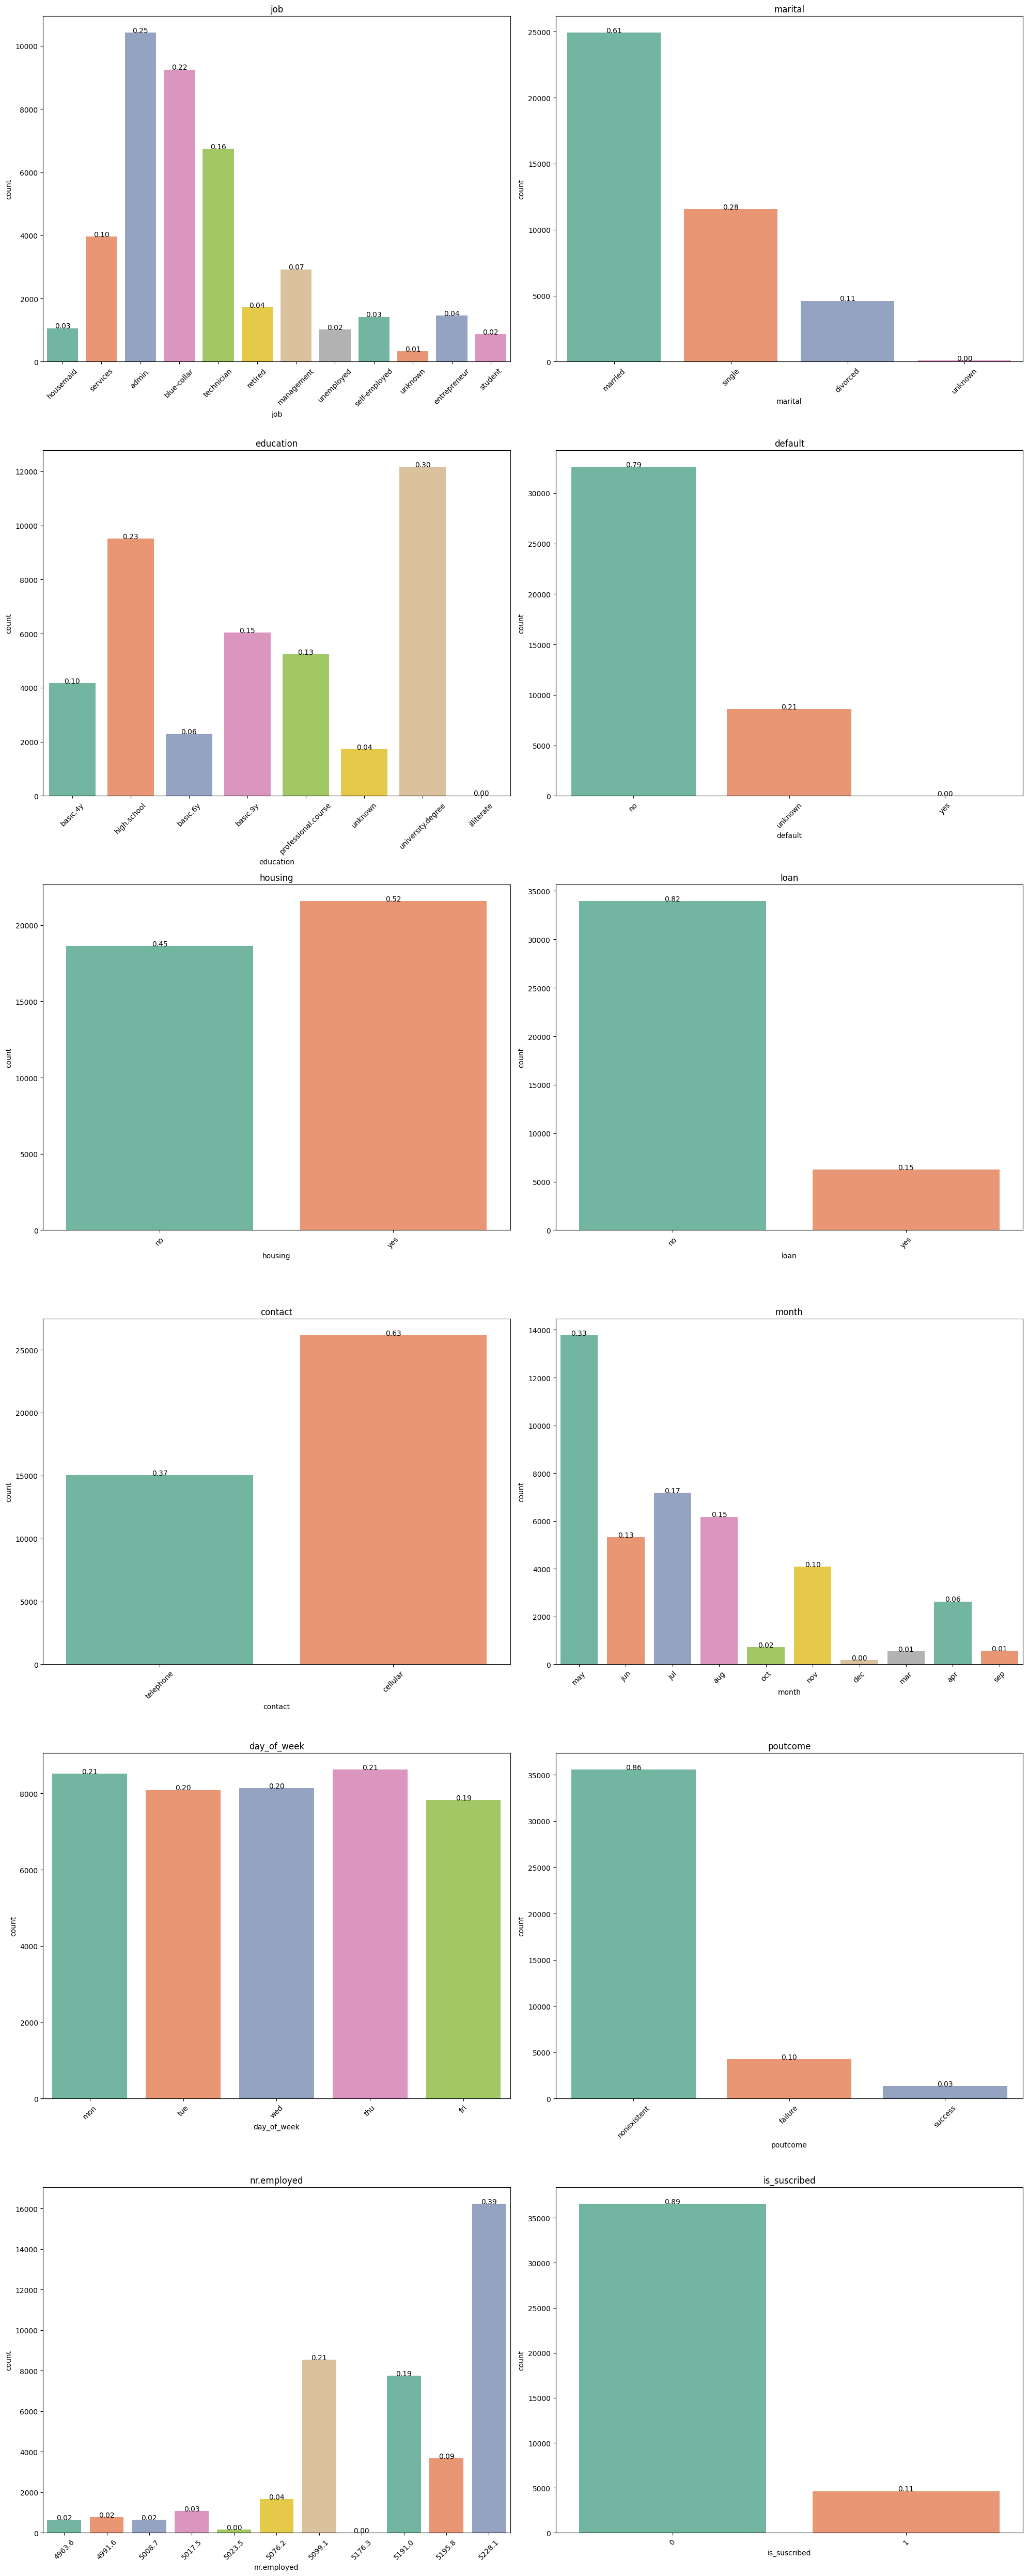

In [17]:
# Créer une figure
plt.figure(figsize=(20,50))

# Créer un barplot pour chaque variable qualitative
for i, var in enumerate(str_cols):
    plt.subplot(len(str_cols)//2, 2, i+1)
    ax = sns.countplot(data=df_raw, x=var, palette="Set2")
    plt.title(var)
    plt.xticks(rotation=45)
    # Ajouter les proportions
    total = float(len(df_raw))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/total),
                ha="center") 

# Afficher la figure
plt.tight_layout()
plt.show()

Tenemos algunos unknown en la educacion, el defecto y el job. Podremos imputar por la mediana por el job y la educacion porque cada uno representa menos de 0.01% y 0.04% respectivamente. Pero para el defecto es un poquita mas complicado porque representan 20% de la variable y no quiero imputar por el momento para no perder informaciones o para no crear ruido. Una tecnica possible aqui es imputar de manera iterativa o con el KNN para ver si mejora el modelo predictivo o no. No voy a hacerlo aqui y voy a guardar esta variable tal cual. 

# ANALISIS BIVARIATE

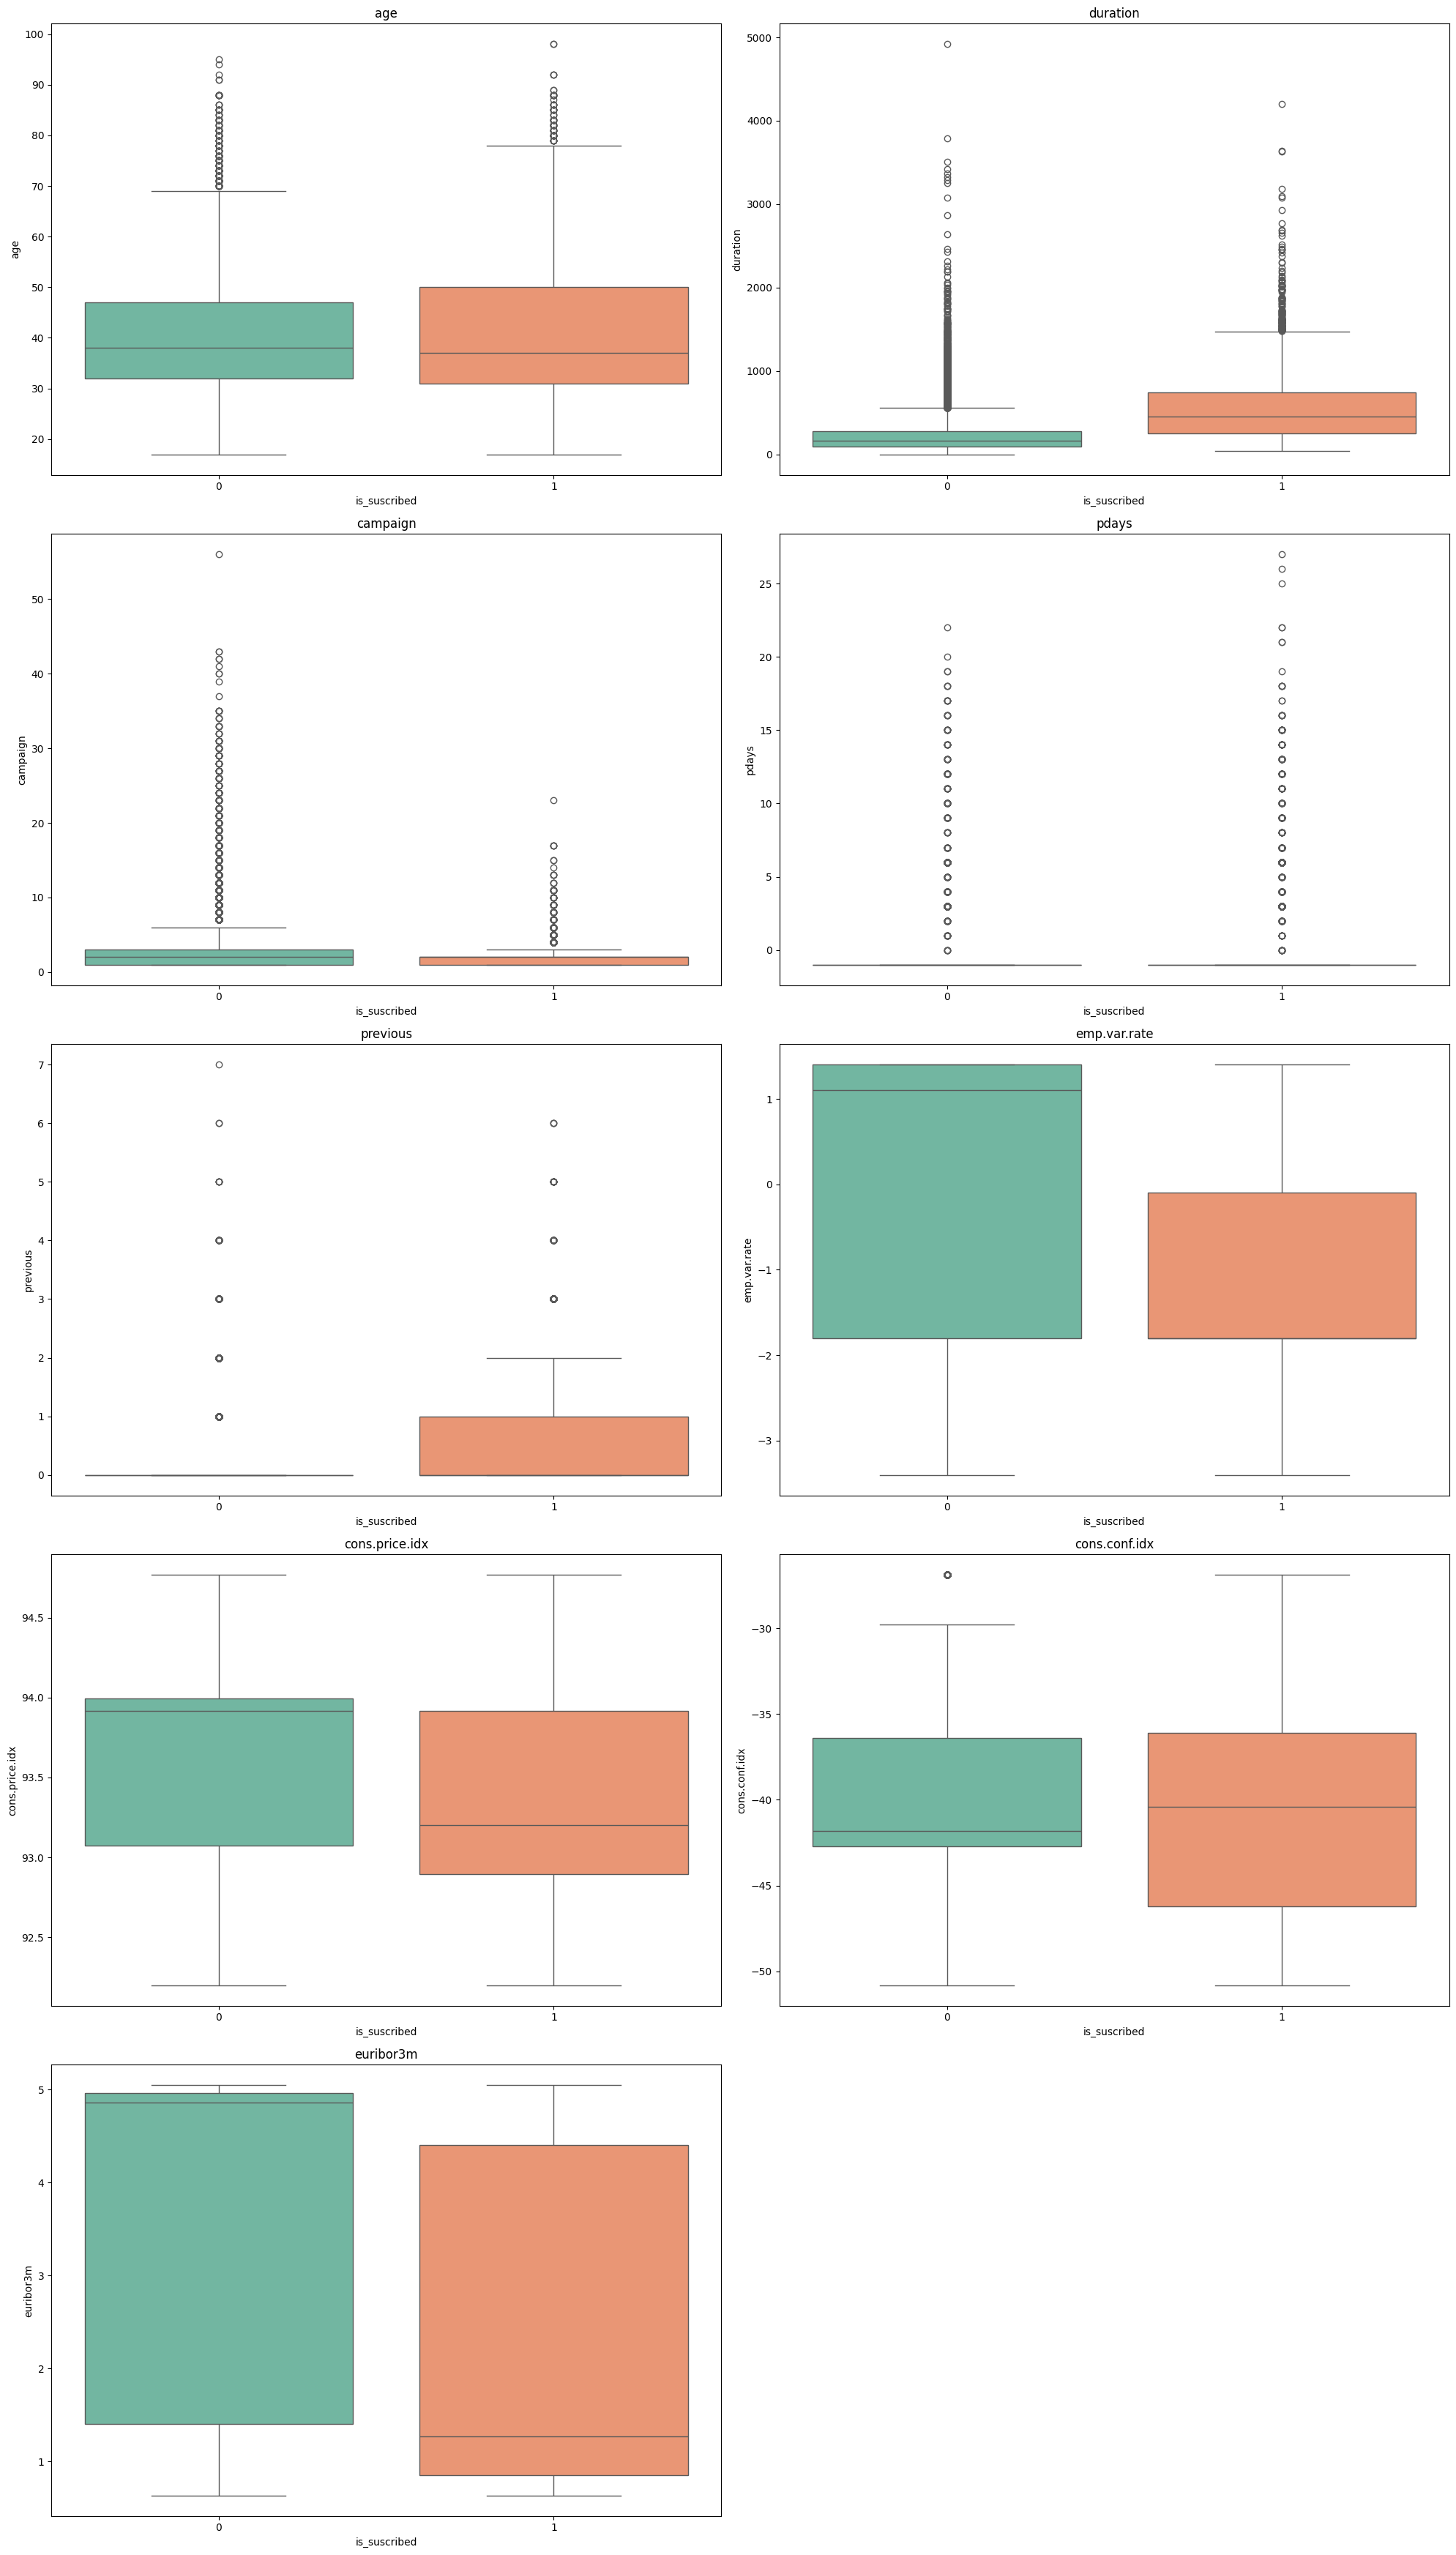

In [18]:
# Créer une figure
plt.figure(figsize=(20,35))

# Créer un boxplot pour chaque variable quantitative
for i, var in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data = df_raw, x = 'is_suscribed', y = var, palette="Set2")
    plt.title(var)

# Afficher la figure
plt.tight_layout()
plt.show()

Con esta visualizacion, lo que podemos ver es que cuanto mas una llamada dura, hay mas suerte de firmar un deposito a plazo. Podemos ver tambien la importancia de los contactos realizado antes de la campana para obtener una firma. 

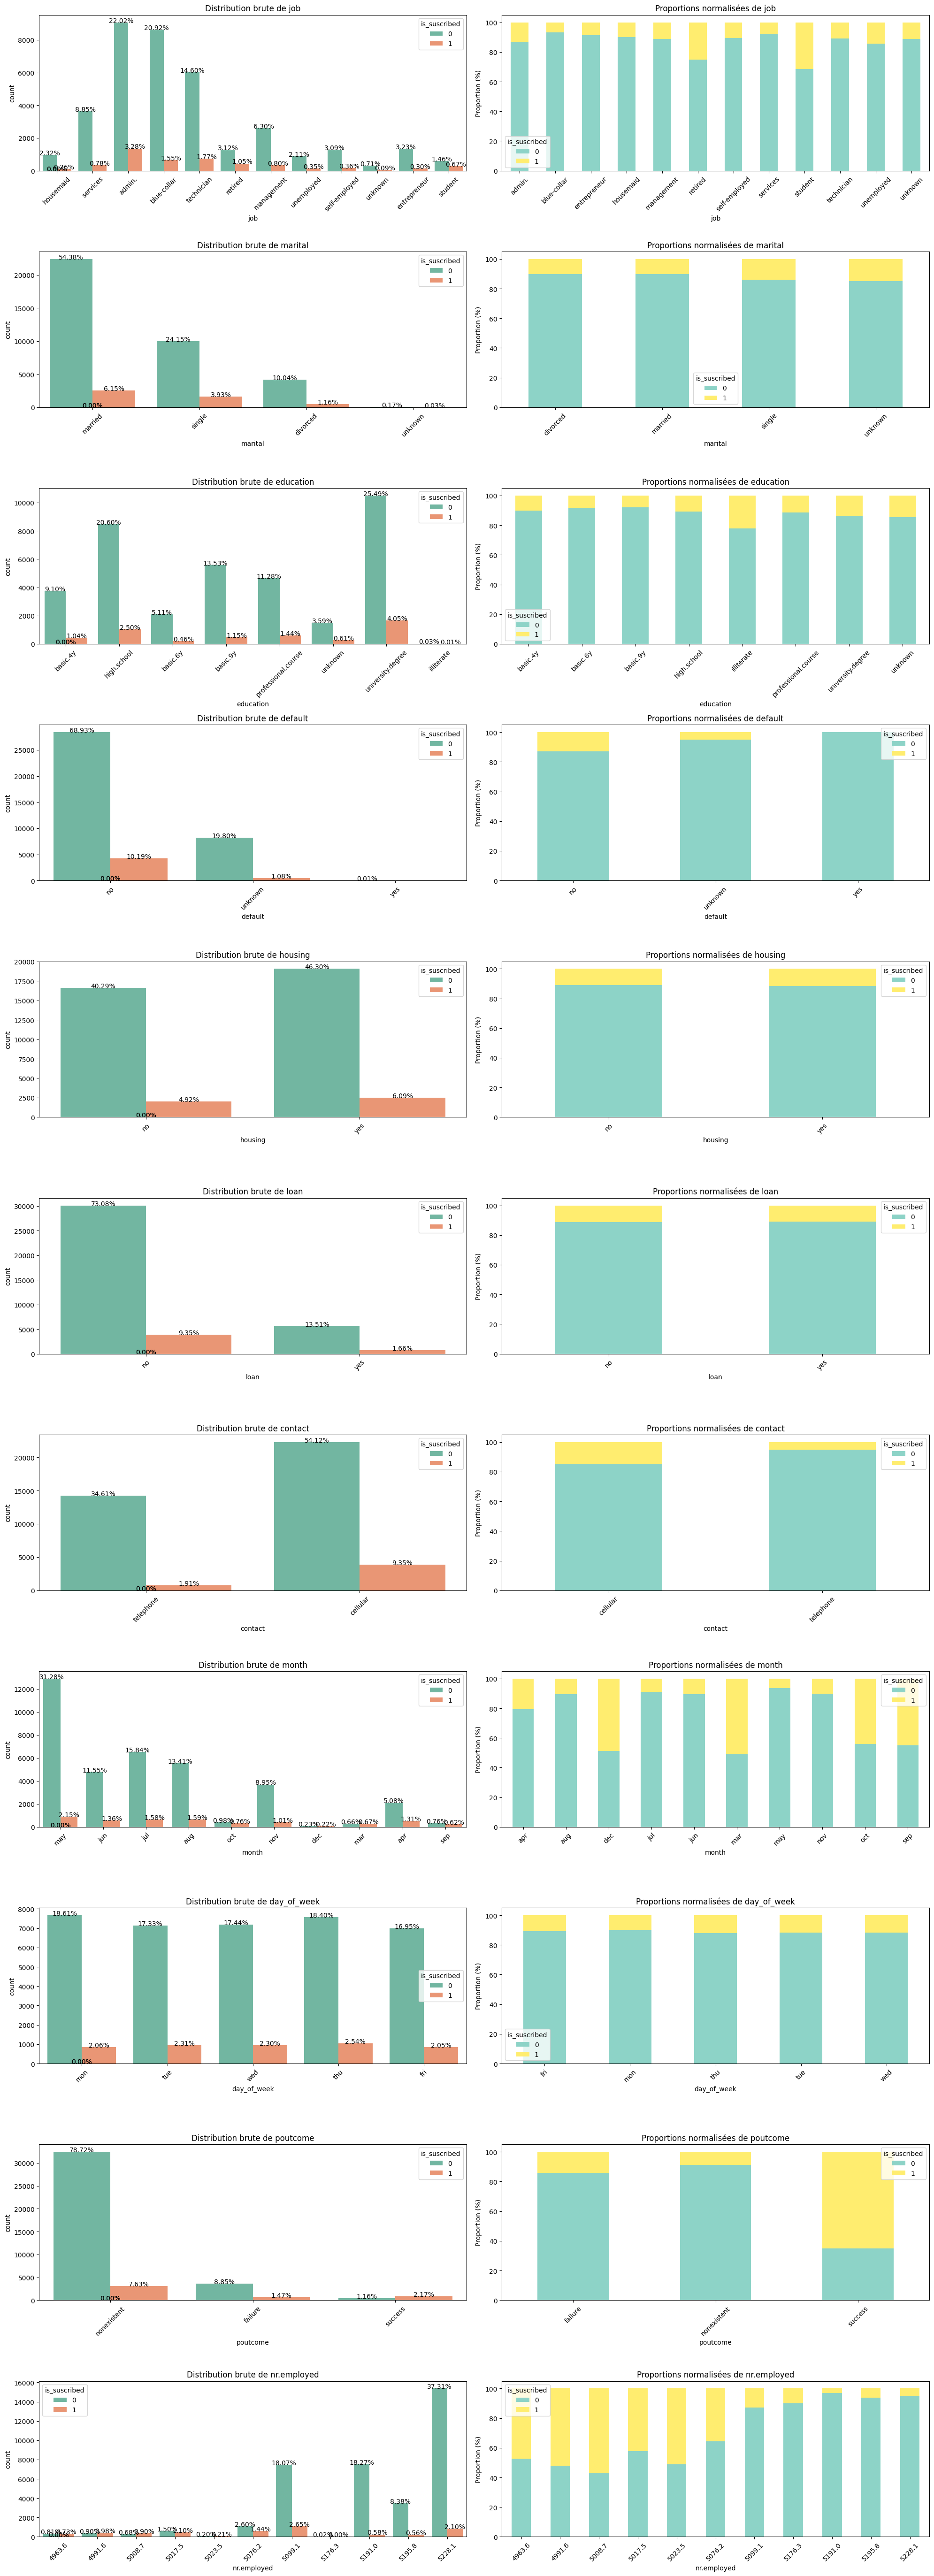

In [19]:
# Variables qualitatives sans la target
strg_cols_without_target = [col for col in str_cols if col != 'is_suscribed']

# Nombre de variables
n = len(strg_cols_without_target)

# Création de la figure avec 2 colonnes (countplot + barplot empilé)
fig, axes = plt.subplots(n, 2, figsize=(20, n * 5))  # Plus large pour afficher deux plots

for i, var in enumerate(strg_cols_without_target):
    # --- Graphique 1 : Countplot brut ---
    ax1 = axes[i, 0] if n > 1 else axes[0]  # Gestion du cas où il n'y a qu'une seule variable
    sns.countplot(data=df_raw, x=var, hue='is_suscribed', palette="Set2", ax=ax1)
    
    # Ajouter les proportions au-dessus des barres
    total = len(df_raw)
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total:.2%}', ha="center")

    ax1.set_title(f"Distribution brute de {var}")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    # --- Graphique 2 : Crosstab barplot empilé ---
    ax2 = axes[i, 1] if n > 1 else axes[1]  # Gestion du cas où il n'y a qu'une seule variable
    crosstab = pd.crosstab(df_raw[var], df_raw["is_suscribed"], normalize="index") * 100
    crosstab.plot(kind="bar", stacked=True, colormap="Set3", ax=ax2)

    ax2.set_title(f"Proportions normalisées de {var}")
    ax2.set_ylabel("Proportion (%)")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


Tenemos muchas informaciones diferentes aqui. Son los clientes con un puesto de adminitrador que hacen los mas suscripción. En porcentage de la clase de job, son los estudiantes y los jubilados que hacen una suscripción.\
No vemos diferencia con el status marital, de educacion (los iiliterates son los con la mayor propension a hacer una suscripción). \
Podemos ver tambien que las personas sin defectuo han una mayor propension a la suscripción. \
No parece haber un mejor dia. Por los meses, el mes de mayo es el mas importante pero con una propension muy debil frente a diciembre, marzo y octubre.\
Parece que las llamadas al cellular tienen mas suerte.\
Las campanas previas con exitos parece tener mas suerte.\
Y por fin, hay empleos muy efficiente frente a la cantidad de sus llamadas como el caso del empleado 5508.7 frente al 5228.1.

# PROPROCESSING

In [75]:
df_clean = df_raw.copy()

## MISSING VALUES

Ahora podemos tratar los nulos. Sabemos que en marital y education hay unknowns.

In [76]:
# Imputación de valores faltantes

# Listamos las columnas con valores nulos
df_missing = df_clean.isnull().sum()
df_missing = df_missing[df_missing > 0]
df_missing = df_missing.reset_index()

# Calculamos el porcentaje de valores nulos 
df_missing['percentage'] = df_missing[0] / len(df_clean) * 100
df_missing

,index,0,percentage
0,housing,990,2.404313
1,loan,990,2.404313
2,emp.var.rate,95,0.230717
3,euribor3m,60,0.145716


Vamos a imputar los nulos de euribor3m, emp.var.rate con la mediana y loan, housing, marital y education con la moda. Imputamos porque cada uno representan menos de 3% de las variables.

In [77]:
df_clean['housing'].fillna(df_clean['housing'].mode()[0], inplace=True)
df_clean['loan'].fillna(df_clean['loan'].mode()[0], inplace=True)
df_clean['marital'] = df_clean['marital'].replace('unknown', df_clean['marital'].mode()[0])
df_clean['education'] = df_clean['education'].replace('unknown', df_clean['education'].mode()[0])

df_clean['emp.var.rate'].fillna(df_clean['emp.var.rate'].median(), inplace=True)
df_clean['euribor3m'].fillna(df_clean['euribor3m'].median(), inplace=True)

In [78]:
df_clean.isnull().sum()[df_clean.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

## OUTLIERS

In [79]:
def windsorize_upper(df, columns, upper_percentile=0.95):
    """
    Windsorize the upper tail of a series at a given percentile.
    """
    for col in columns:
        upper_limit = df[col].quantile(upper_percentile)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    return df

df_clean = windsorize_upper(df_clean, numeric_cols)

In [80]:
df_clean[numeric_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T.style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
age,41176.000000,39.715878,9.614423,17.000000,32.000000,38.000000,47.000000,55.000000,58.000000,58.000000,58.000000
duration,41176.000000,241.559258,193.483609,0.000000,102.000000,180.000000,319.000000,551.000000,753.000000,753.000000,753.000000
campaign,41176.000000,2.333908,1.701373,1.000000,1.000000,2.000000,3.000000,5.000000,7.000000,7.000000,7.000000
pdays,41176.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
previous,41176.000000,0.136609,0.343438,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
emp.var.rate,41176.000000,0.083580,1.570025,-3.400000,-1.800000,1.100000,1.400000,1.400000,1.400000,1.400000,1.400000
cons.price.idx,41176.000000,93.574107,0.576028,92.201000,93.075000,93.749000,93.994000,94.465000,94.465000,94.465000,94.465000
cons.conf.idx,41176.000000,-40.674067,4.271536,-50.800000,-42.700000,-41.800000,-36.400000,-36.100000,-33.600000,-33.600000,-33.600000
euribor3m,41176.000000,3.622622,1.733831,0.634000,1.344000,4.857000,4.961000,4.964000,4.966000,4.966000,4.966000


# ANALYSIS MULTIVARIATE

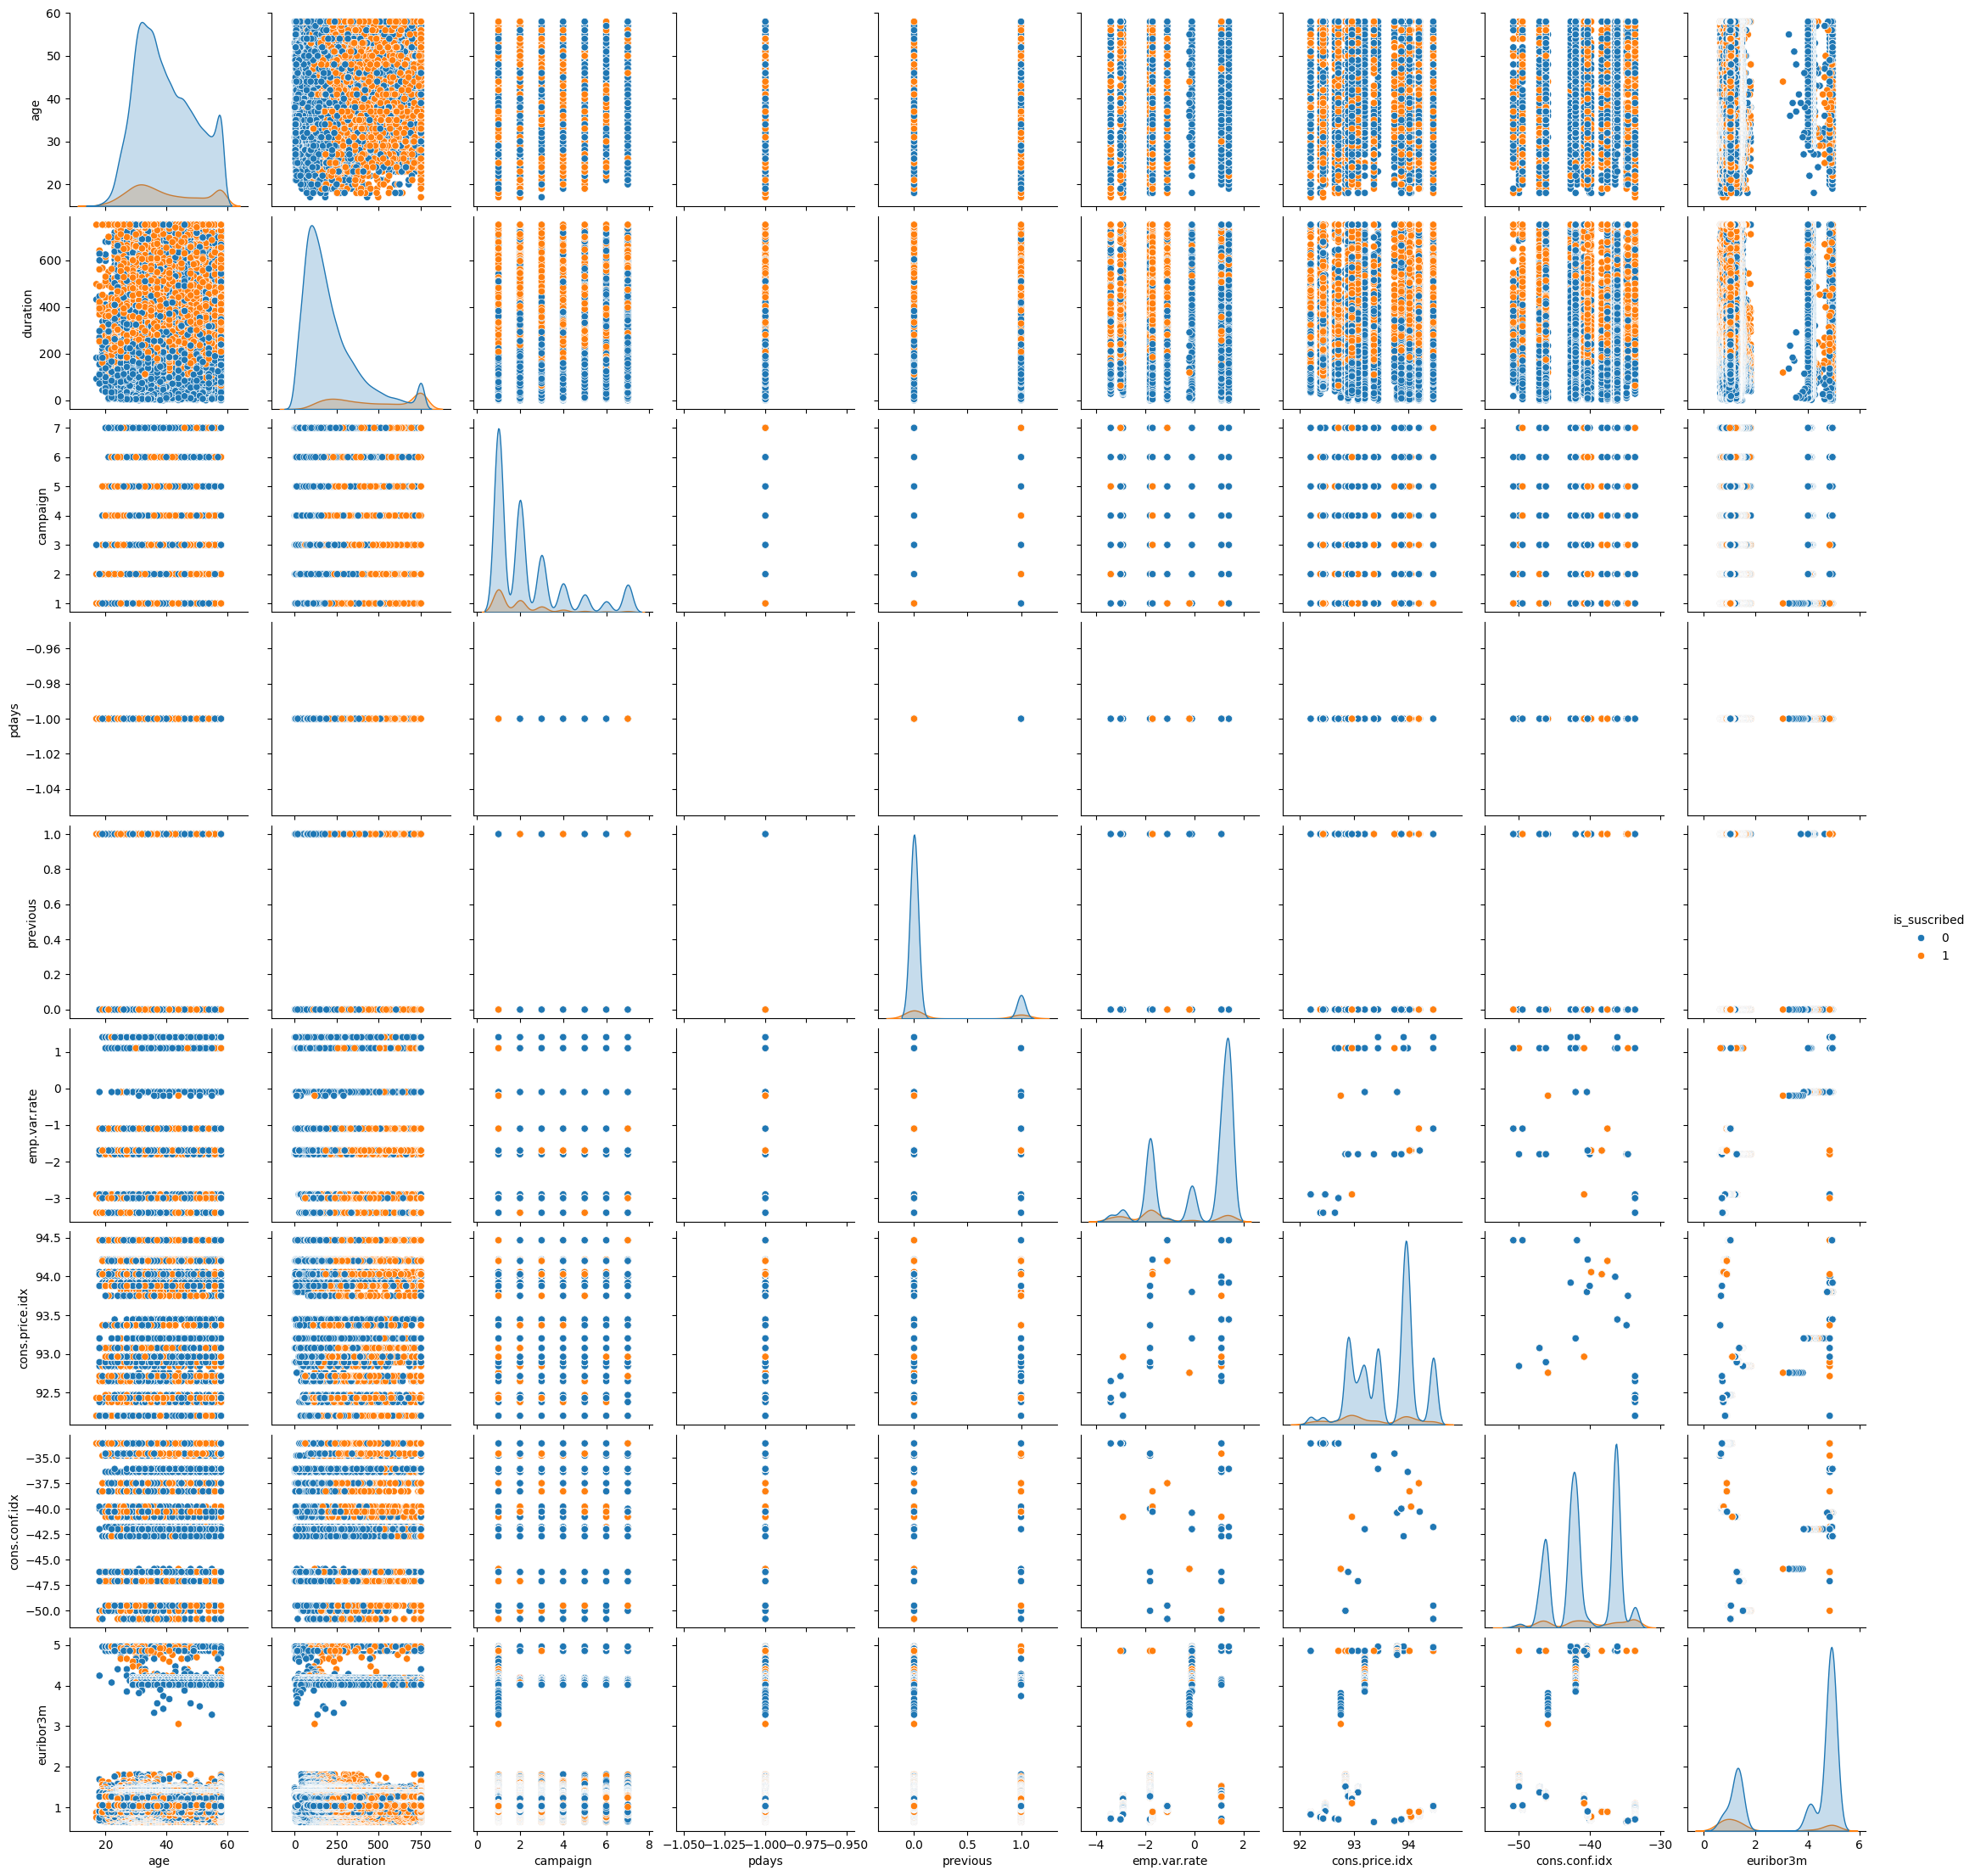

In [71]:
df_clean['is_suscribed'] = df_clean['is_suscribed'].astype(object)
sns.pairplot(df_clean[numeric_cols + ['is_suscribed']], diag_kind='kde', hue='is_suscribed')
plt.show()

No tenemos mucha informacion importante aqui. Podemos ver de nuevo que las suscripciones se realicen a partir de 200 segundos. 

## CORRELATIONS

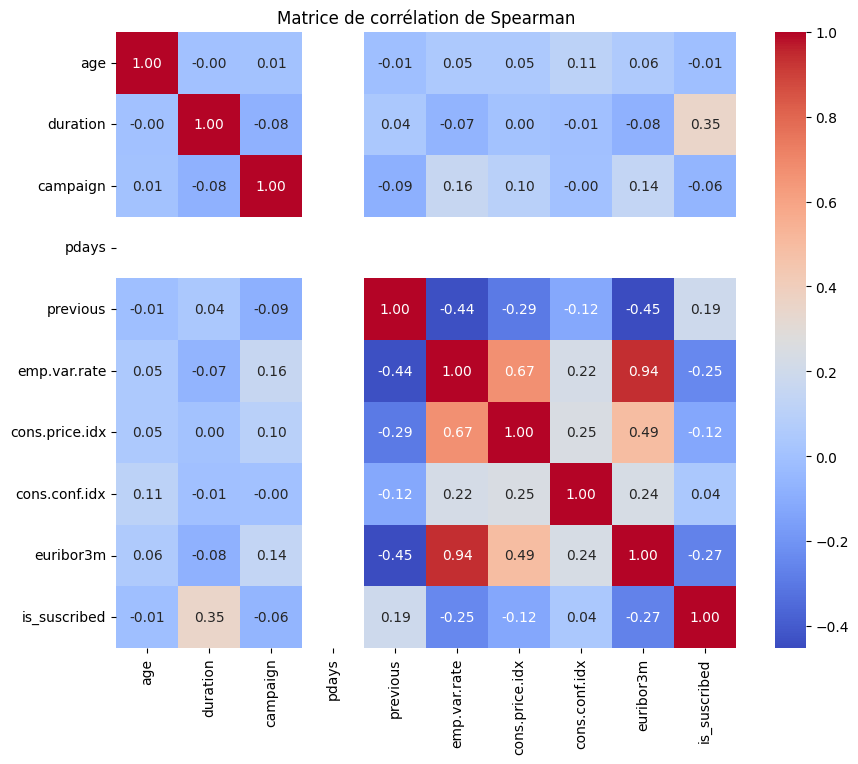

In [81]:
plt.figure(figsize=(10, 8))
corr = df_clean[numeric_cols+["is_suscribed"]].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

Podemos ver una gran correlacion entre euribor3m y emp.var.rate lo que reprensenta multicolinealidad asi vamos a quitar la variable emp.var.rate. La variable cons.price.idx y emp.var.rate tienen tambien una correlacion considerable. 

In [82]:
df_clean = df_clean.drop(columns=['emp.var.rate'])

In [83]:
corr["is_suscribed"].sort_values(ascending=False)

is_suscribed      1.000000
duration          0.348320
previous          0.193522
cons.conf.idx     0.041053
age              -0.013309
campaign         -0.063517
cons.price.idx   -0.124092
emp.var.rate     -0.247107
euribor3m        -0.266208
pdays                  NaN
Name: is_suscribed, dtype: float64

Frente a la variable objetiva, no tenemos una grand relacion. Podemos ver de nuevo la importancia de la variable Duration con un score de correlacion de 0.35 (la mayor aqui). Para la variable pdays, con la windsorizacion tenemos solo una unica valor asi no es tan importante guardarla.

## CHI 2

In [ ]:
# Análizamos la relación entre variables categóricas mediante chi-cuadrado
def chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p
def analyze_categorical_relationships(df, categorical_cols):
    results = []
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            col1 = categorical_cols[i]
            col2 = categorical_cols[j]
            chi2, p = chi_square_test(df, col1, col2)
            results.append((col1, col2, chi2, p))
    return results

categorical_relationships = analyze_categorical_relationships(df_clean, str_cols)
results_df = pd.DataFrame(categorical_relationships, columns=['col1', 'col2', 'chi2', 'p-value'])
results_df['significant'] = results_df['p-value'] < 0.05

results_df['p-value'] = results_df['p-value'].apply(lambda x: '{:.2e}'.format(x))
results_df['chi2'] = results_df['chi2'].apply(lambda x: '{:.2f}'.format(x))
results_df['chi2'] = results_df['chi2'].astype('float')
results_df.sort_values(by='chi2', ascending=False, inplace=True)
pd.set_option('display.max_rows', None)
results_df

,col1,col2,chi2,p-value,significant
58,month,nr.employed,165204.25,0.00e+00,True
1,job,education,34328.91,0.00e+00,True
54,contact,nr.employed,18772.01,0.00e+00,True
51,contact,month,15288.83,0.00e+00,True
63,poutcome,nr.employed,15019.92,0.00e+00,True
65,nr.employed,is_suscribed,6975.06,0.00e+00,True
9,job,nr.employed,5228.50,0.00e+00,True
57,month,poutcome,4858.01,0.00e+00,True
6,job,month,4569.92,0.00e+00,True
64,poutcome,is_suscribed,4230.52,0.00e+00,True


In [ ]:
def cramers_v(x, y):
    """
    Calcula Cramér's V para dos variables categóricas.
    
    Parámetros:
    - x, y: Series o arrays de pandas que representan variables categóricas.
    
    Retorna:
    - Valor de Cramér's V, entre 0 y 1.
    """
    tabla_cruzada = pd.crosstab(x, y)

    # calculamos chi2, el p valor asociado, los grados de libertad y la tabla esperada
    chi2, p, dof, expected = chi2_contingency(tabla_cruzada)
    #hacemos la suma de la tabla cruzada global para obetener el nº total de datos y normalizar 
    n = tabla_cruzada.sum().sum()
    min_dim = min(tabla_cruzada.shape) - 1 # Cálculo de la dimensión mínima
    if min_dim == 0:
        return np.nan # si una de la variable tiene solo un valor, no se puede calcular la v de cramer. Habría que eliminarla
    
    return np.sqrt(chi2 / (n * min_dim))

# Calcular Cramér's V para cada par de variables categóricas
cramers_v_results = []
for i in range(len(str_cols)):
    for j in range(i + 1, len(str_cols)):
        col1 = str_cols[i]
        col2 = str_cols[j]
        cv = cramers_v(df_clean[col1], df_clean[col2])
        cramers_v_results.append((col1, col2, cv))
cramers_v_df = pd.DataFrame(cramers_v_results, columns=['col1', 'col2', 'Cramér\'s V'])
cramers_v_df['Cramér\'s V'] = cramers_v_df['Cramér\'s V'].apply(lambda x: '{:.2f}'.format(x))
cramers_v_df.sort_values(by='Cramér\'s V', ascending=False, inplace=True)
cramers_v_df.head(30)

,col1,col2,Cramér's V
54,contact,nr.employed,0.68
58,month,nr.employed,0.67
51,contact,month,0.61
63,poutcome,nr.employed,0.43
65,nr.employed,is_suscribed,0.41
1,job,education,0.37
64,poutcome,is_suscribed,0.32
59,month,is_suscribed,0.27
57,month,poutcome,0.24
53,contact,poutcome,0.24


## ANOVA & T-TEST

In [ ]:
# Test Anova
group1_duration = df_clean[df_clean['is_suscribed'] == 0]['duration']
group2_duration = df_clean[df_clean['is_suscribed'] == 1]['duration']

# Perform the ANOVA test
anova_result = f_oneway(group1_duration, group2_duration)

print('ANOVA test results:')
print(f'F-statistic: {anova_result.statistic}')
print(f'p-value: {anova_result.pvalue}')

"""
En este caso, el p-valor es menor que 0.05, lo que indica que hay diferencias significativas en las medias de los grupos, 
por lo que podemos rechazar la hipótesis nula de que las medias son iguales. 
Esto sugiere que la tarifa diaria (adr) tiene un efecto significativo en la cancelación de reservas."""

ANOVA test results:
F-statistic: 8438.393452158949
p-value: 0.0


'\nEn este caso, el p-valor es menor que 0.05, lo que indica que hay diferencias significativas en las medias de los grupos, \npor lo que podemos rechazar la hipótesis nula de que las medias son iguales. \nEsto sugiere que la tarifa diaria (adr) tiene un efecto significativo en la cancelación de reservas.'

In [ ]:
# Test t de Student
def t_student(gp1, gp2):
    stat, p = ttest_ind(gp1, gp2)

    print(f"Statistique de test : {stat:.3f}")
    print(f"P-value : {p:.3f}")

    # Interprétation
    if p < 0.05:
        print("Les groupes sont significativement différents.")
    else:
        print("Aucune différence significative entre les groupes.")
        return None


In [ ]:
group1_previous = df_clean[df_clean['is_suscribed'] == 0]['previous']
group2_previous = df_clean[df_clean['is_suscribed'] == 1]['previous']
t_student(group1_previous, group2_previous)

Statistique de test : -40.027
P-value : 0.000
Les groupes sont significativement différents.


## MUTUAL INFORMATION

In [ ]:
df_selection = df_clean.copy()
target_encoder = TargetEncoder()
df_selection['is_suscribed'] = df_selection['is_suscribed'].astype(int)
df_selection['month'] = target_encoder.fit_transform(df_selection[['month']], df_selection['is_suscribed'])
df_selection['nr.employed'] = target_encoder.fit_transform(df_selection[['nr.employed']], df_selection['is_suscribed'])

str_cols_dummies = [col for col in str_cols if col not in ['month', 'nr.employed',"is_suscribed"]]
encoder = OneHotEncoder(sparse_output =False)
encoded_array = encoder.fit_transform(df_selection[str_cols_dummies])
df_dummies = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(str_cols_dummies))
df_selection = pd.concat([df_selection.drop(columns=str_cols_dummies), df_dummies], axis=1)


In [ ]:
df_selection.head()

,age,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56.0,0.064246,261.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57.0,0.065327,149.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37.0,0.065327,226.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40.0,0.064946,151.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56.0,0.062469,307.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Calcul de l'information mutuelle
X = df_selection.drop(columns=["is_suscribed"])
y = df_selection["is_suscribed"]
y = y.astype(int)
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

mi_series_grouped = mi_series.groupby(lambda x: x.split('-')[0]).sum().reset_index()
mi_series_grouped['type_column'] = mi_series_grouped['index'].apply(
    lambda col: 'numeric' if col in numeric_cols else 'categorical' if col in str_cols else 'other'
)
mi_series_grouped.sort_values(by=0, ascending=False).reset_index(drop=True).rename(columns={'index': 'col_name', 0: 'importance'}).style.background_gradient(cmap='coolwarm')

,col_name,importance,type_column
0,duration,0.077927,numeric
1,euribor3m,0.073931,numeric
2,cons.conf.idx,0.068369,numeric
3,nr.employed,0.063493,categorical
4,cons.price.idx,0.062264,numeric
5,emp.var.rate,0.053983,numeric
6,month,0.029143,categorical
7,poutcome_success,0.028700,other
8,poutcome_nonexistent,0.019966,other
9,contact_cellular,0.018609,other
